# Data Mining Project on Human Activity Recognition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from utils import timeseries_visualization, load_data, visualize_hist_and_boxplot, visualize_pca
np.random.seed(1)
random.seed(1)


## Exploratory Data Analysis


The first step is loading the data. The dataset consists of sensor data measured on 18 separate subjects, which is stored in 18 separate csv file. 
As such, we will combine all the files in a single dataframe, adding a feature 'subject' which contains the subject id, because it might be helpful for classification purposes

In [2]:
df = load_data()
df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,501
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,501
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,501
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,501
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,501
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,518
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,518
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,518
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,518


Let's visualize the data of one subject from the back and thigh sensors. The data is a timeseries, so we will plot the activity recorded by the sensors as a function of the timesteps, so we can see the evolution over time

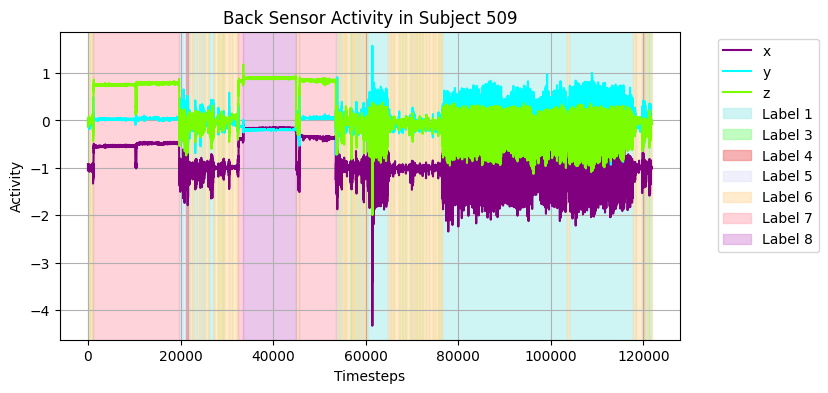

In [3]:
timeseries_visualization(df, 509, 'Back Sensor Activity in Subject 509', 'back')

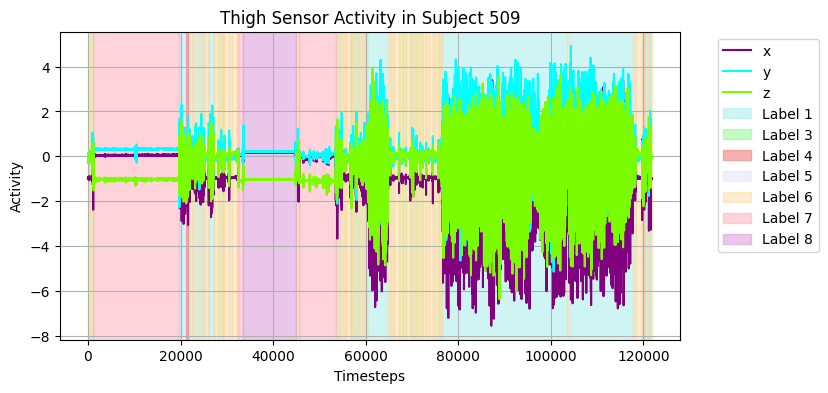

In [4]:
timeseries_visualization(df, 509, 'Thigh Sensor Activity in Subject 509', 'thigh')

From the accelerometor plot, we notice some important characteristics of the dataset.
    
1) The data seem to vary considerably between the classes. More specifically, for label 1 it is much more fluctuating while it tends to stay between a smaller range for labels 4, 8 and 6.

2) There are clearly some patterns that can help us identify the classes.

3) There are not many records for labels 3, 4, and 5 compared to the rest of the data. This might make it challenging  for a classifier to distinguish samples belonging to this class. As such, for this study, we decide to remove these samples from the dataset and only work on recognizing other activities

4) Since the data is very fluctuating for label 1, it might be useful to introduce lagged features for classification purposes, because the differences between the activity for label 1 at one timesteps and the previous can be substantially large compared to the rest of the labels

The data is multidimensional, as such it poses challenges for visualization purposes. It can be useful to do PCA and plot the first two principal components 

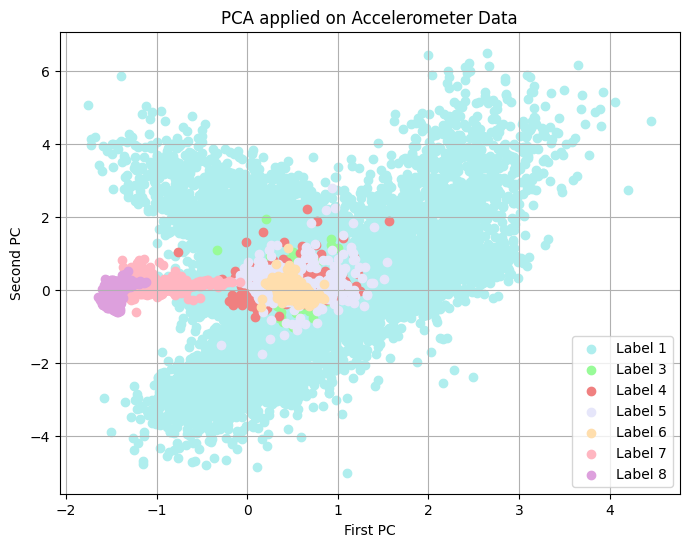

In [5]:
visualize_pca(df, 509)

Looking at the PCA, we notice 2 things:
1)  The points in class 7, 8 seem to form distinct clusters. We expect the classifier to find it somewhat easy to not misclassify one class for another 

2)  The points in class 5, 6, 3 and 4 seem to overlap with each other. It might be complex to distinguish them, so that's another reason why we will discard for this project the labels 3,4 and 5

3) The majority class (1) seems to overlap between every class. It may not be particularly suited to the dataset to apply kMeans clustering since the clusters are not linearly separated. The dataset is also clearly unbalanced, and we need to take care of this. 


In [6]:
"""
# Autocorrelation Analysis


exclude_columns = ['timestamp', 'subject_id', 'label']
df_autocorrelation = df.drop(exclude_columns, axis=1)

# Calculate autocorrelation using numpy
#autocorrelation = np.correlate(sensor_data - sensor_data.mean(), sensor_data - sensor_data.mean(), mode='full')
# Calculate autocorrelations for each feature
autocorrelations = df.apply(lambda col: col.autocorr(), axis=0)

# Create a scatter plot matrix
sns.set(style="ticks")
sns.pairplot(autocorrelations, kind='scatter')
plt.show()
"""


'\n# Autocorrelation Analysis\n\n\nexclude_columns = [\'timestamp\', \'subject_id\', \'label\']\ndf_autocorrelation = df.drop(exclude_columns, axis=1)\n\n# Calculate autocorrelation using numpy\n#autocorrelation = np.correlate(sensor_data - sensor_data.mean(), sensor_data - sensor_data.mean(), mode=\'full\')\n# Calculate autocorrelations for each feature\nautocorrelations = df.apply(lambda col: col.autocorr(), axis=0)\n\n# Create a scatter plot matrix\nsns.set(style="ticks")\nsns.pairplot(autocorrelations, kind=\'scatter\')\nplt.show()\n'

## Data preprocessing

### Outlier detection

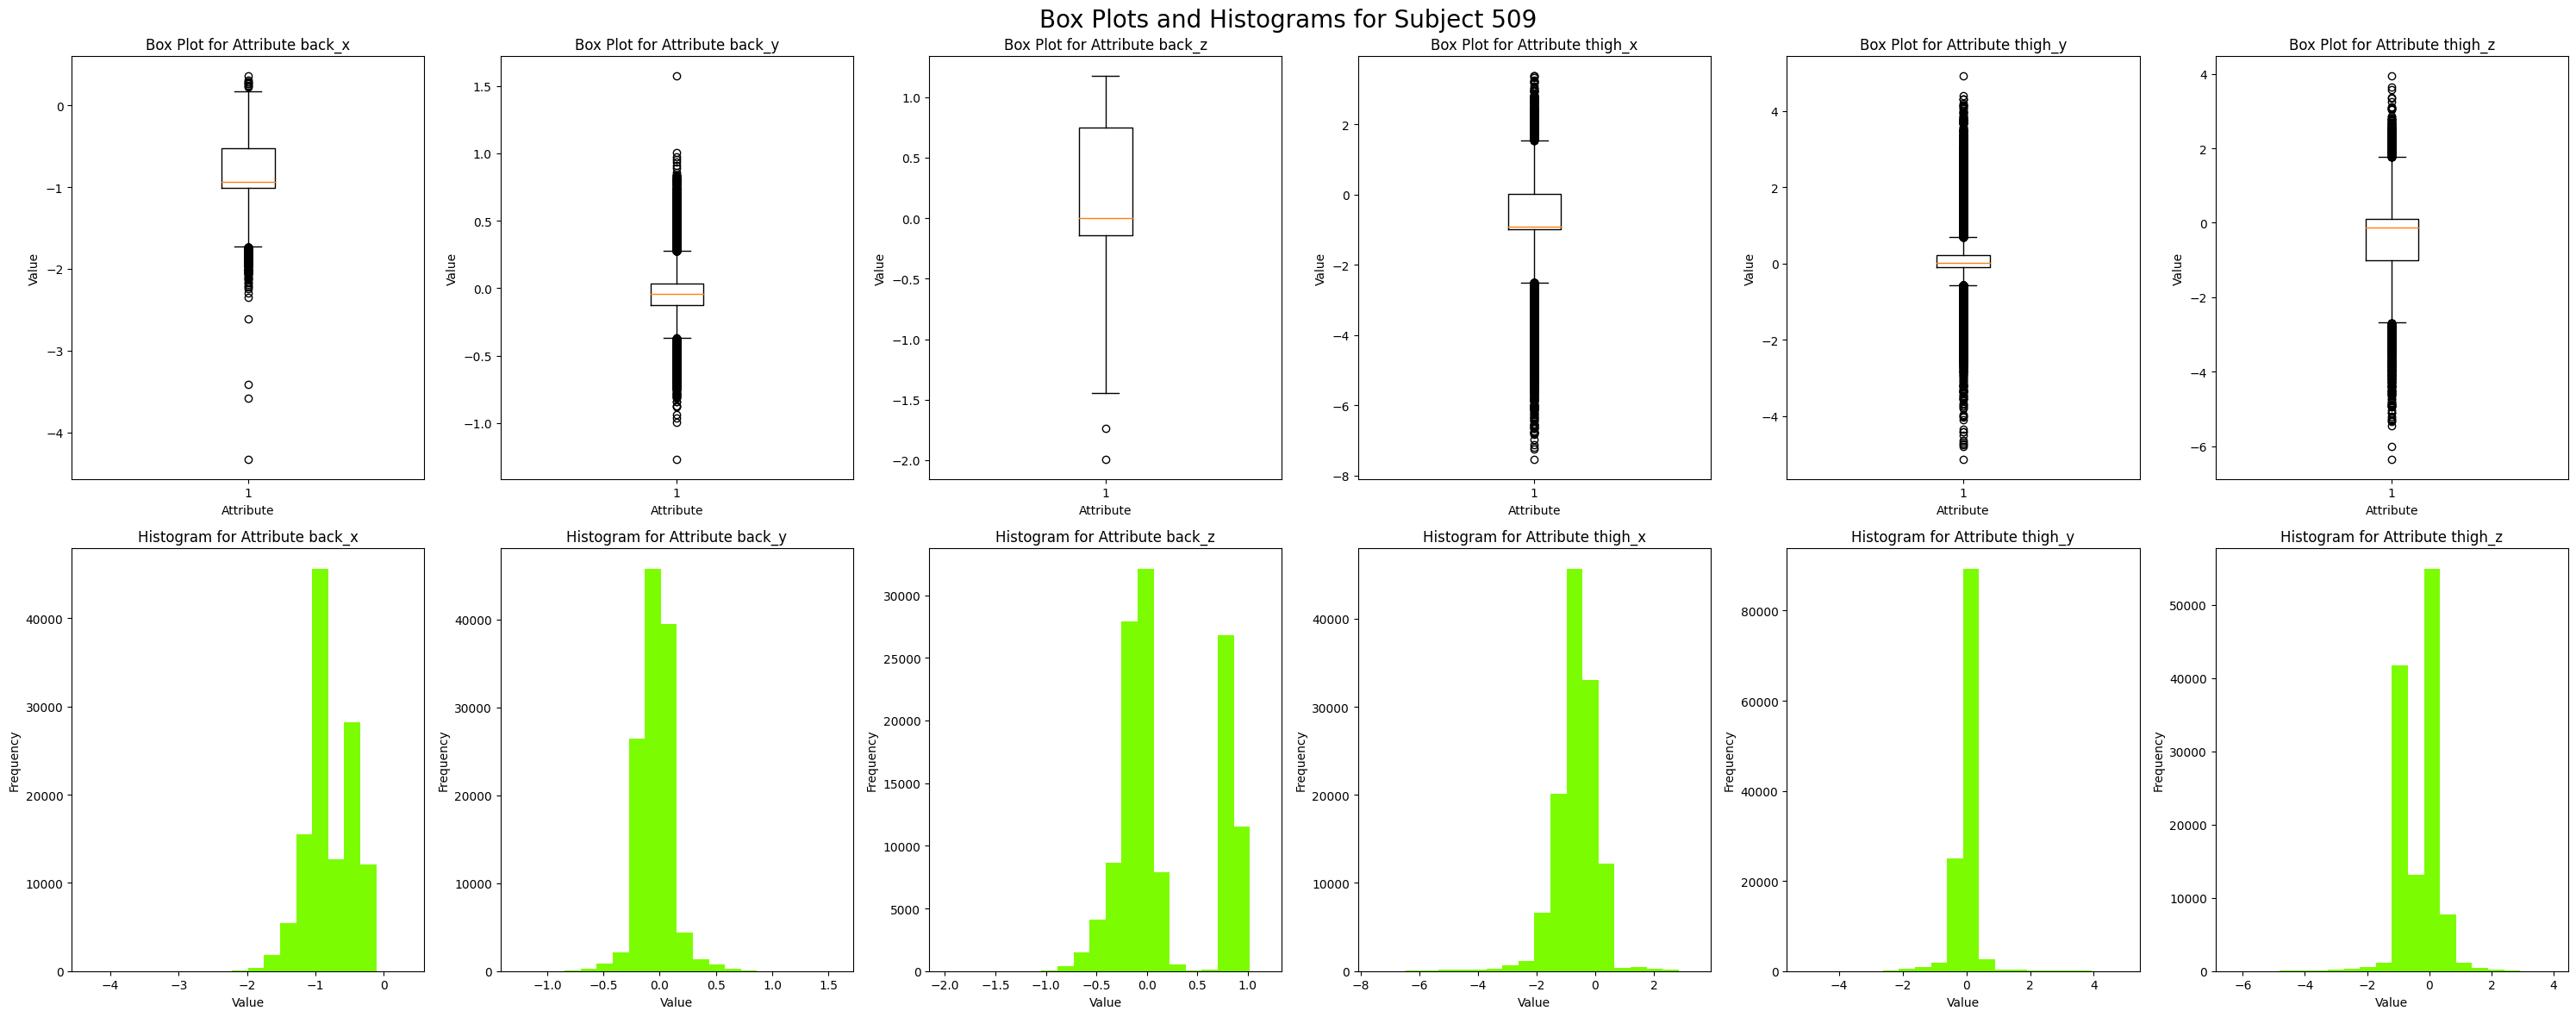

In [3]:
visualize_hist_and_boxplot(df, 509) 

The dataset presents a lot of outliers, discarding them might be helpful for the classifier.

In [8]:
df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,501
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,501
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,501
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,501
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,501
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,518
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,518
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,518
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,518


### Feature Engineering

In [9]:
# Load data and compute lagged features
#df_lagged = load_data(lagged=True, exclude_ids=True)
# Dropping NaN values
#df_lagged = df_lagged.dropna()
#df_lagged


In [10]:
# Compute other features (from paper)
#df_lagged['back_x_energy'] = df_lagged['back_x'] ** 2
#df['back_x_energy'] = df['back_x'] ** 2
"""
# Compute the mean gravity for 'back_y' and 'thigh_x'
mean_back_y = df_lagged['back_y'].mean()
mean_thigh_x = df_lagged['thigh_x'].mean()

# Compute the cross-axis mean gravity feature
df['cross_axis_mean_gravity'] = (mean_back_y+mean_thigh_x) / 2

# Compute the median gravity for 'thigh_z'
df['thigh_z_median_gravity'] = df_lagged['thigh_z'].median()

"""

"\n# Compute the mean gravity for 'back_y' and 'thigh_x'\nmean_back_y = df_lagged['back_y'].mean()\nmean_thigh_x = df_lagged['thigh_x'].mean()\n\n# Compute the cross-axis mean gravity feature\ndf['cross_axis_mean_gravity'] = (mean_back_y+mean_thigh_x) / 2\n\n# Compute the median gravity for 'thigh_z'\ndf['thigh_z_median_gravity'] = df_lagged['thigh_z'].median()\n\n"

### Data normalization

Next, we normalize the data

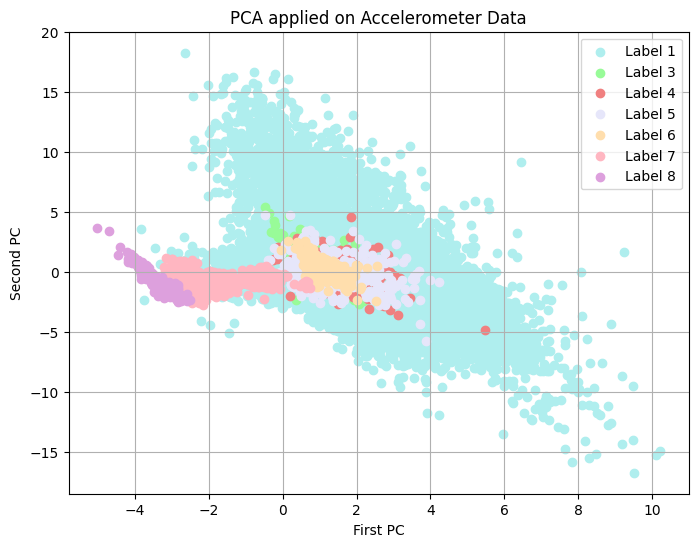

In [11]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the numerical columns (excluding the 'subject_id' column)
#numerical_columns = [col for col in df_lagged.columns if col != 'subject_id' and col!='label' and col!='timestamp']
#df_lagged[numerical_columns] = scaler.fit_transform(df_lagged[numerical_columns])


numerical_columns = [col for col in df.columns if col != 'subject_id' and col!='label' and col!='timestamp']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


visualize_pca(df,509)

In [12]:
# Remove from the data records with labels being 3,4 and 5
df = df[~df['label'].isin([3, 4, 5])]

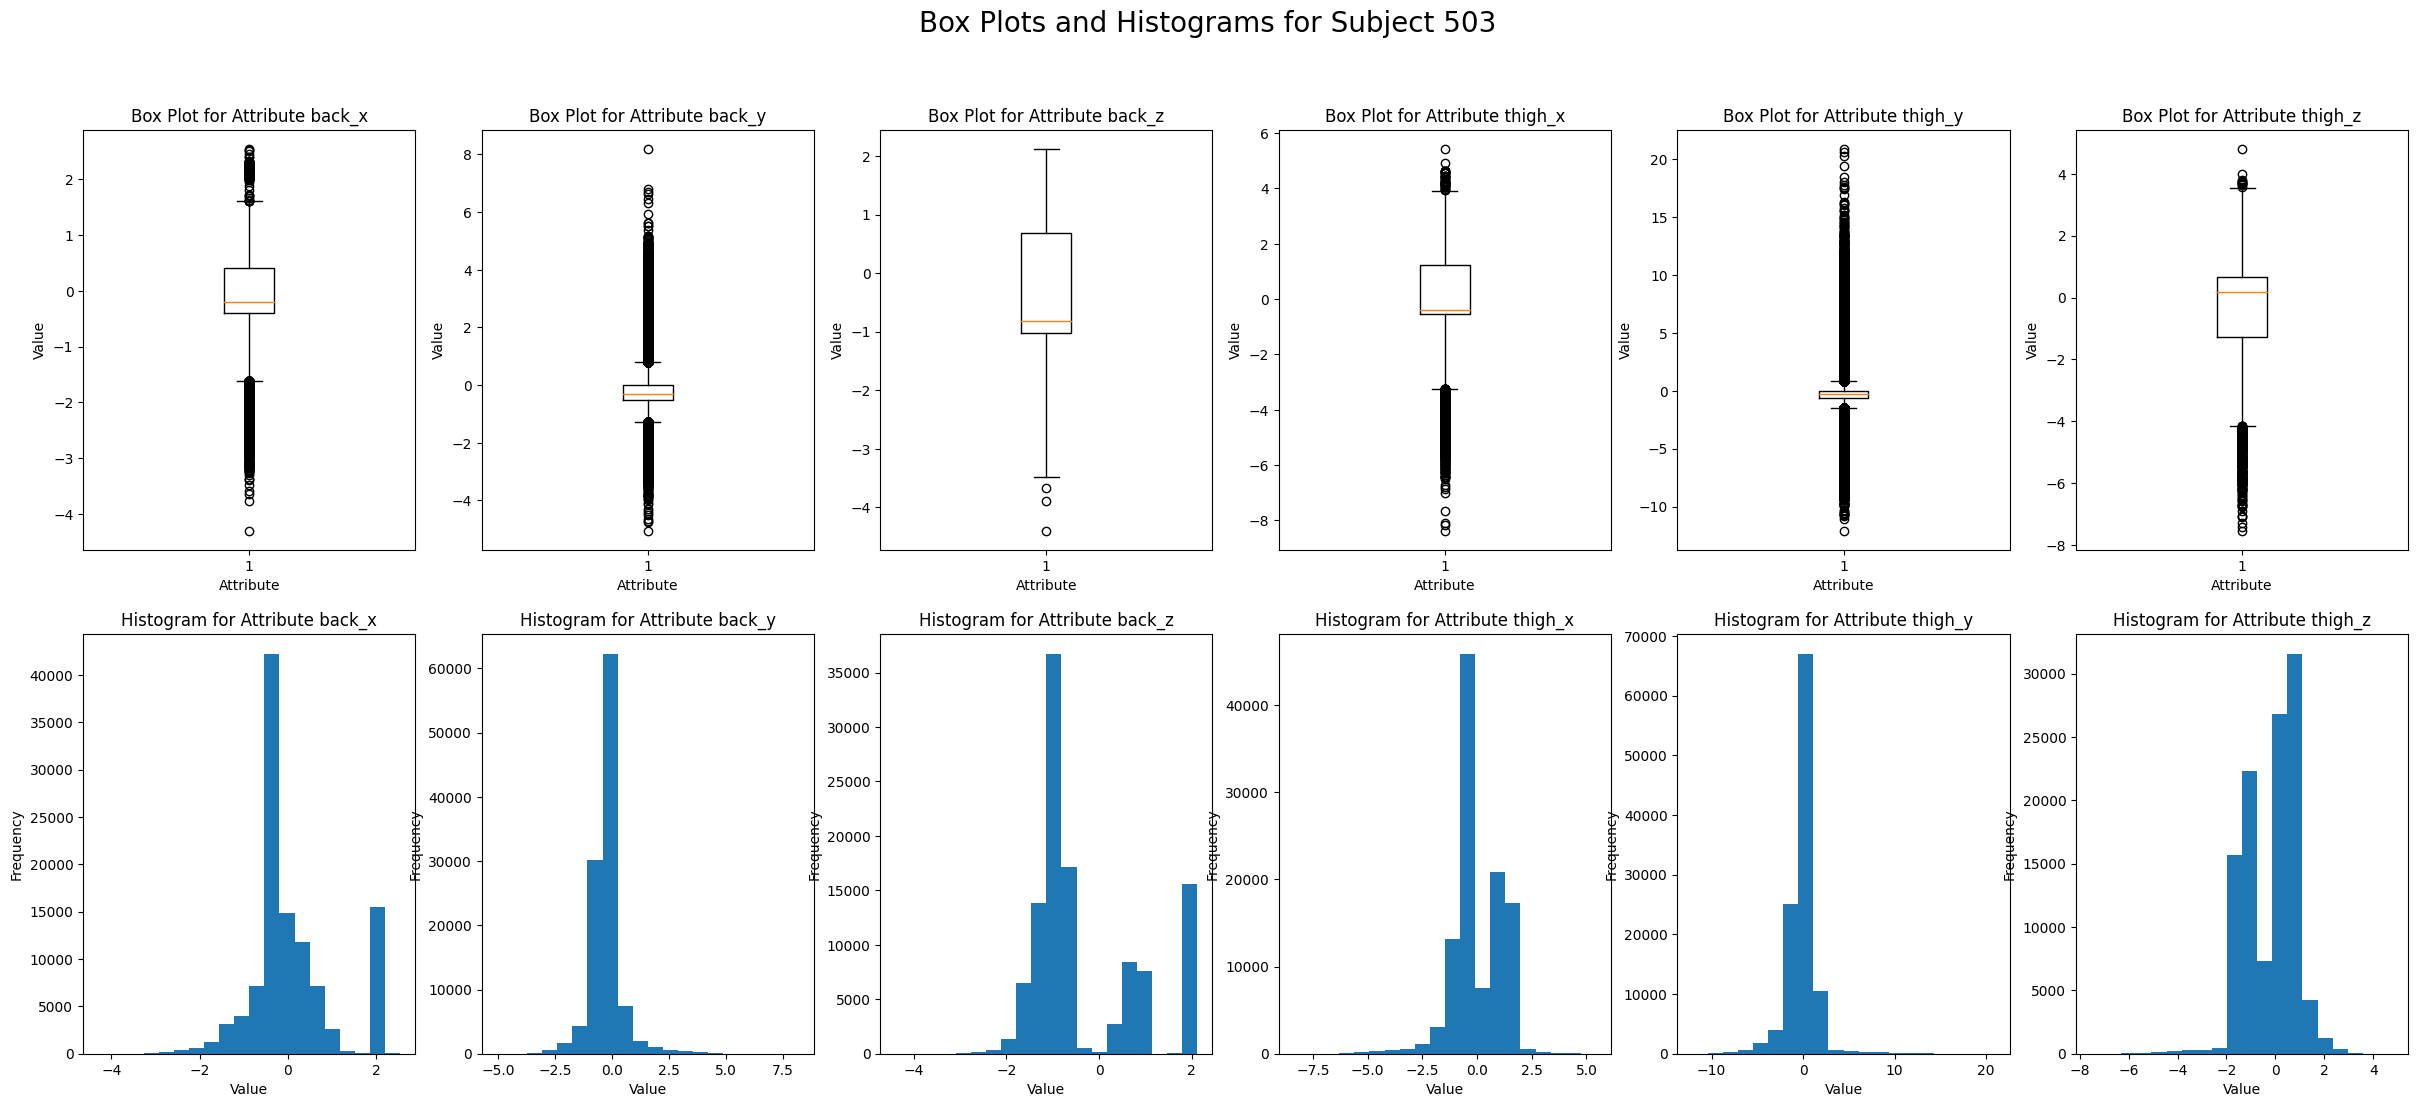

In [13]:
visualize_hist_and_boxplot(df, 503) 

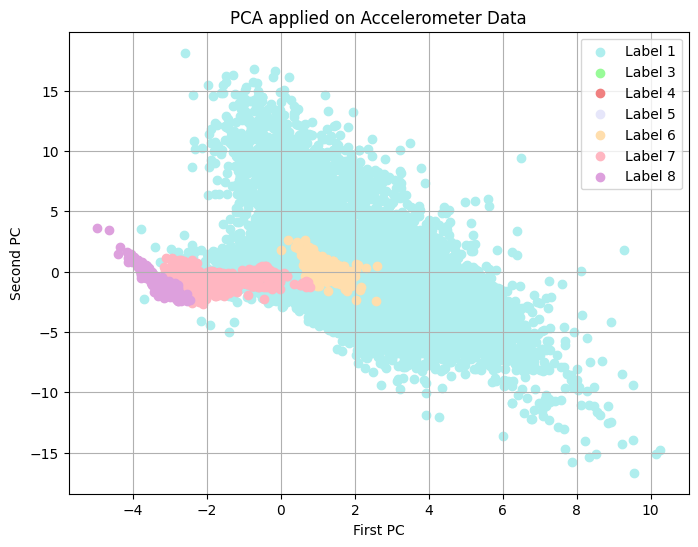

(2184001, 9)


In [14]:
visualize_pca(df, 509)
print(df.shape)

### Data subsampling

Subsample the data for computational reasons. Stratified sampling is used to ensure that in the subsample the proportion of labels is kept the same

In [15]:
"""
stratified_sampled_data = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.7))
visualize_pca(stratified_sampled_data, 509)
print(stratified_sampled_data.shape)
# TODO : create small test independent test set
# Separate the features and target variable
exclude_columns = ['timestamp', 'subject_id', 'label']
X_stratified_sampled = stratified_sampled_data.drop(exclude_columns, axis=1).values
y_stratified_sampled = stratified_sampled_data['label'].values

"""

"\nstratified_sampled_data = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.7))\nvisualize_pca(stratified_sampled_data, 509)\nprint(stratified_sampled_data.shape)\n# TODO : create small test independent test set\n# Separate the features and target variable\nexclude_columns = ['timestamp', 'subject_id', 'label']\nX_stratified_sampled = stratified_sampled_data.drop(exclude_columns, axis=1).values\ny_stratified_sampled = stratified_sampled_data['label'].values\n\n"

##  k Nearest Neighbors Classifier

First, we separate the label column from the dataset

In [17]:

exclude_columns = ['timestamp', 'subject_id', 'label']
X = df.drop(exclude_columns, axis=1).values
y = df['label'].values

We create an independent test for evaluation

In [18]:
# TODO: Create independent test set

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
print(y_test.shape)

(436801,)


Next, we employ Stratified 10-fold cross validation to find the optimal parameter 'n_neighbors'

In [18]:
# Credit: chatGPT was partially employed for coding

# Values of n_neighbors to be tested
n_neighbors_values = range(3,20)

# Create a stratified 10-fold cross-validation object
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# Dictionary to store F1 scores for each n_neighbors value
f1_scores = {}
predictions = {key: [] for key in n_neighbors_values}
actual = {key: [] for key in n_neighbors_values}

for n_neighbors in n_neighbors_values:
    print(f'Tuning hyperparameter n_neighbors: Current Value {n_neighbors}')
    # Lists to store cross-validation results for the current n_neighbors value
    cv_f1_scores = []

    # Perform stratified 10-fold cross-validation
    # TODO: change this with train and validation split
    for train_index, test_index in stratified_kfold.split(X_train, y_train):
        
        # Define the KNN classifier 
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)  
        
        # Get training and testing folds
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Fit the KNN classifier 
        knn.fit(X_train_fold, y_train_fold)
    

        # Make predictions on the validation data
        y_pred = knn.predict(X_test_fold)
        actual[n_neighbors].append(y_test_fold)
        predictions[n_neighbors].append(y_pred)

        # Calculate and store the F1 score for this fold
        f1 = f1_score(y_test_fold, y_pred, average='micro')  
        print('Score is', f1)
        cv_f1_scores.append(f1)

    # Calculate and store the mean F1 score for the current n_neighbors value
    f1_scores[n_neighbors] = np.mean(cv_f1_scores)

# Find the n_neighbors value with the highest mean F1 score
best_n_neighbors = max(f1_scores, key=f1_scores.get)
best_mean_f1 = f1_scores[best_n_neighbors]

print("Mean F1 Scores:")
for n_neighbors, mean_f1 in f1_scores.items():
    print(f"n_neighbors={n_neighbors}: Mean F1 Score={mean_f1}")

print(f"Best n_neighbors value: {best_n_neighbors}")
print(f"Best Mean F1 Score: {best_mean_f1}")


Tuning hyperparameter n_neighbors: Current Value 3
Score is 0.9610903159340659
Score is 0.9613495879120879
Score is 0.9609701236263736
Tuning hyperparameter n_neighbors: Current Value 4
Score is 0.9633104395604396
Score is 0.9631061126373627
Score is 0.9627833104395604
Tuning hyperparameter n_neighbors: Current Value 5
Score is 0.9619745879120879
Score is 0.9618664148351649
Score is 0.9615281593406594
Tuning hyperparameter n_neighbors: Current Value 6
Score is 0.9635611263736263
Score is 0.9633619505494505
Score is 0.9630048076923077
Tuning hyperparameter n_neighbors: Current Value 7
Score is 0.9621136675824176
Score is 0.9618990384615385
Score is 0.9614921016483516
Tuning hyperparameter n_neighbors: Current Value 8
Score is 0.9631971153846154
Score is 0.9630339972527473
Score is 0.962755837912088
Tuning hyperparameter n_neighbors: Current Value 9
Score is 0.9617960164835165
Score is 0.9616809752747253
Score is 0.9612328296703296
Tuning hyperparameter n_neighbors: Current Value 10
Scor

Plot the results of the hyperparameter tuning

Text(0, 0.5, 'F-score')

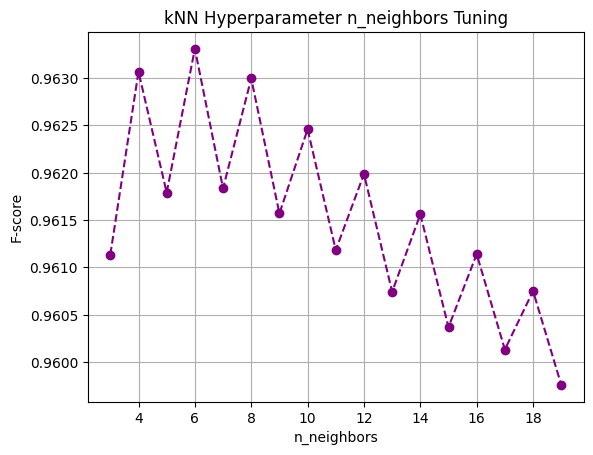

In [19]:
f1_list = [ f1_scores[i] for i in range(3,20)]

#plt.scatter(n_neighbors_values,f1_list, color='purple', marker='x')
plt.plot(n_neighbors_values, f1_list, '--o', color='purple')
plt.grid()
plt.title('kNN Hyperparameter n_neighbors Tuning')
plt.xlabel('n_neighbors')
plt.ylabel('F-score')

Having found the optimal parameters, we train the tree on the entire dataset again and compute the evaluation on the independent test set

In [20]:

# Create a KNN classifier with the optimal parameters
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors)

# Fit the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the training and test sets
#y_train_pred = knn_classifier.predict(X_train)
y_test_pred = knn_classifier.predict(X_test)

Plot the results

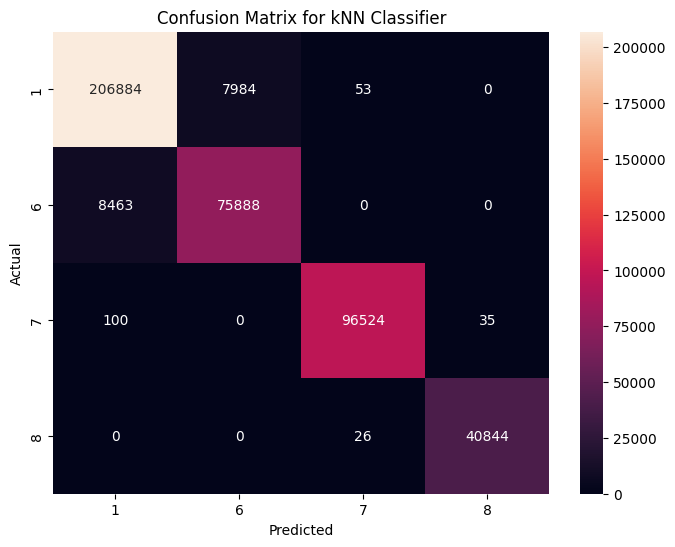

In [21]:


# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",  xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for the test set

# TODO: change this to compare the predictions and the labels for independent test set
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix for kNN Classifier")

y_proba = knn_classifier.predict_proba(X_test)





In [22]:
# TODO: change this for independent test set
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_test_pred)
print(sk_report)

              precision    recall  f1-score   support

           1   0.962605  0.960255  0.961428    215447
           6   0.899669  0.904807  0.902231     83872
           7   0.998603  0.999182  0.998893     96603
           8   0.999364  0.999144  0.999254     40879

    accuracy                       0.961857    436801
   macro avg   0.965060  0.965847  0.965451    436801
weighted avg   0.961922  0.961857  0.961887    436801



In [23]:
# Save the predictions
with open('predictions_kNN.pkl', 'wb') as file:
    data_to_store = y_proba
    pickle.dump(data_to_store, file)

In [24]:
# Save the predictions
with open('f_scores_without_feature_eng.pkl', 'wb') as file:
    data_to_store = f1_list
    pickle.dump(data_to_store, file)